<a href="https://colab.research.google.com/github/aaahza/Toxicity-Model/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
df = pd.read_csv('/content/drive/MyDrive/Toxicity Model/train.csv')
x = df['comment_text']
y = df[df.columns[2:]].values

In [41]:
from tensorflow.keras.layers import TextVectorization

In [42]:
MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=1800, output_mode='int')

In [43]:
vectorizer.adapt(x.values)
vectorized_text = vectorizer(x.values)

In [44]:
from keras.models import load_model
model = tf.keras.models.load_model('/content/drive/MyDrive/Toxicity Model/toxicity.h5')

In [45]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
res = model.predict(np.expand_dims(input_text, 0))
np.expand_dims(input_text, 0)

1/1 [==============================] - 1s 749ms/step


array([[   7, 7158,  397, ...,    0,    0,    0]])

In [46]:
import json
import re

def clean_content(content):
    content = re.sub(r'[\x00-\x1F\x7F]', '', content)
    content = re.sub(r'[^\x00-\x7F]+', '', content)
    return content

def contains_english_alphabet(text):
    return bool(re.search(r'[a-zA-Z]', text))

def parse_instagram_messages(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    messages = data['messages']

    parsed_messages = []

    for message in messages:
        if message['sender_name'] in ['suspiriaana', 'aparna']:
            content = message.get('content', '')
            cleaned_content = clean_content(content)
            if cleaned_content:
                parsed_messages.append(cleaned_content)

    return parsed_messages

In [47]:
# Usage
file_path = '/content/drive/MyDrive/Toxicity Model/Copy of message_1.json'
file_path2 = '/content/drive/MyDrive/Toxicity Model/message_1.json'
new_data = parse_instagram_messages(file_path)
new_data.extend(parse_instagram_messages(file_path2))

print(len(new_data))

5138


In [48]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

vectorized_data = [vectorizer(text) for text in new_data]

padded_data = pad_sequences(vectorized_data, padding='post')

In [49]:
predictions = (model.predict(padded_data)> 0.4).astype(int)

161/161 [==============================] - 9s 49ms/step


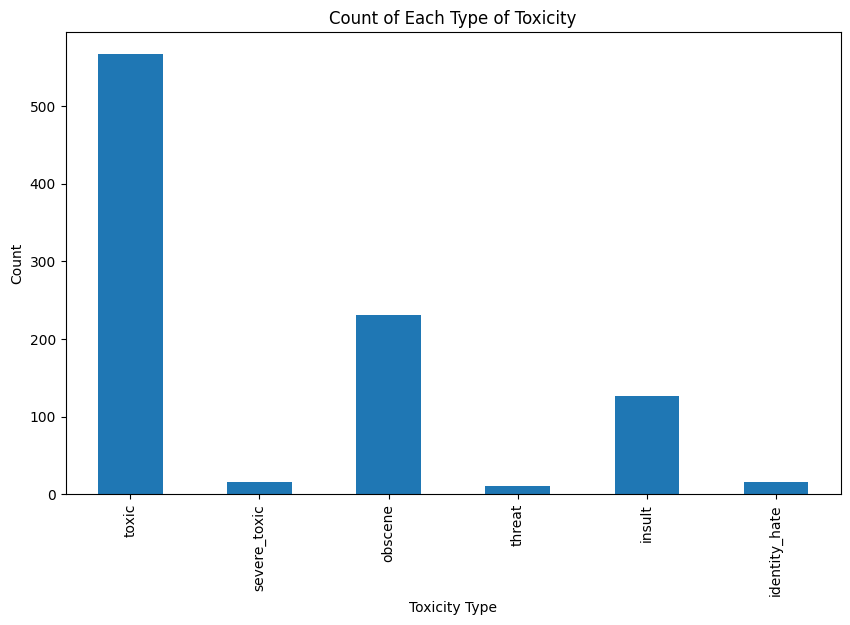

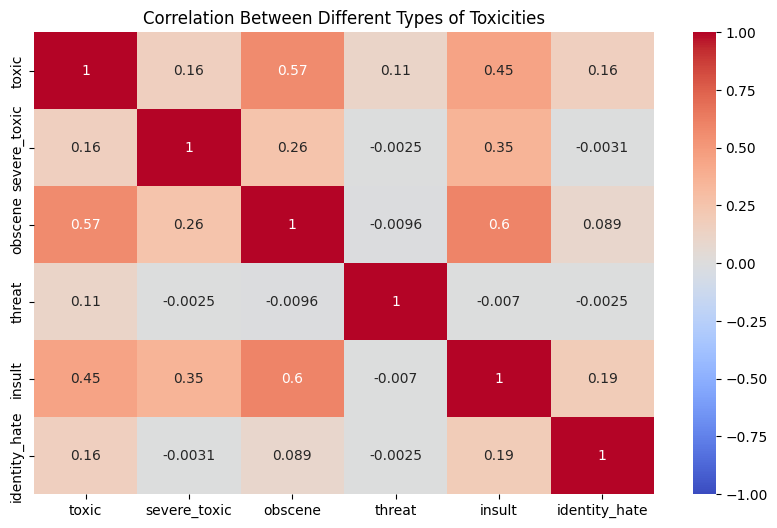

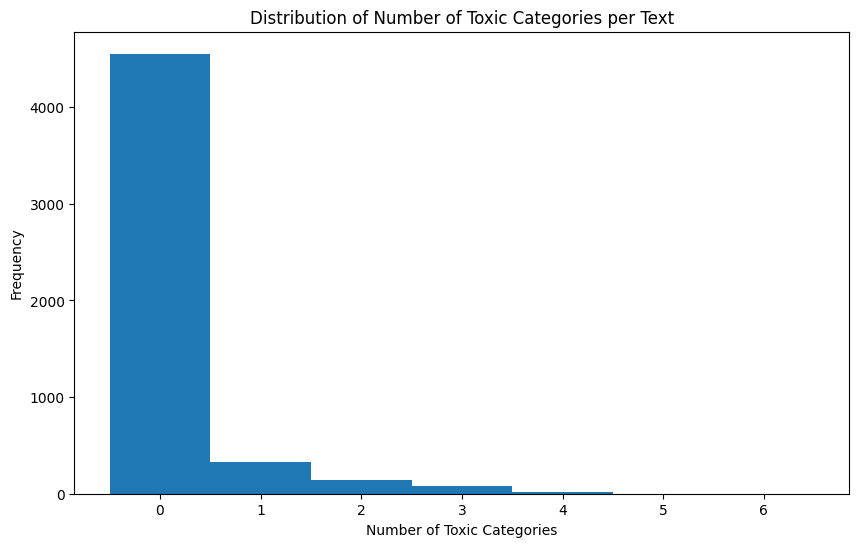

In [50]:
# @title
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming the predictions are in the form described
# predictions = np.array([[0, 0, 0, 0, 0, 0],  # Example data
#                         [0, 0, 0, 0, 0, 0],
#                         [0, 1, 0, 0, 0, 0],
#                         [1, 1, 1, 0, 0, 0],
#                         [0, 0, 0, 0, 1, 0]])

# Column names
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Convert predictions to DataFrame
df = pd.DataFrame(predictions, columns=columns)

# Plot 1: Bar plot for count of each type of toxicity
plt.figure(figsize=(10, 6))
df.sum().plot(kind='bar')
plt.title('Count of Each Type of Toxicity')
plt.ylabel('Count')
plt.xlabel('Toxicity Type')
plt.show()

# Plot 2: Heatmap for correlation between different types of toxicities
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Different Types of Toxicities')
plt.show()

# Plot 3: Histogram for distribution of the number of toxic categories per text
plt.figure(figsize=(10, 6))
df.sum(axis=1).plot(kind='hist', bins=range(8), align='left')
plt.title('Distribution of Number of Toxic Categories per Text')
plt.xlabel('Number of Toxic Categories')
plt.ylabel('Frequency')
plt.show()

In [51]:
alt_predictions = model.predict(padded_data)

161/161 [==============================] - 7s 43ms/step


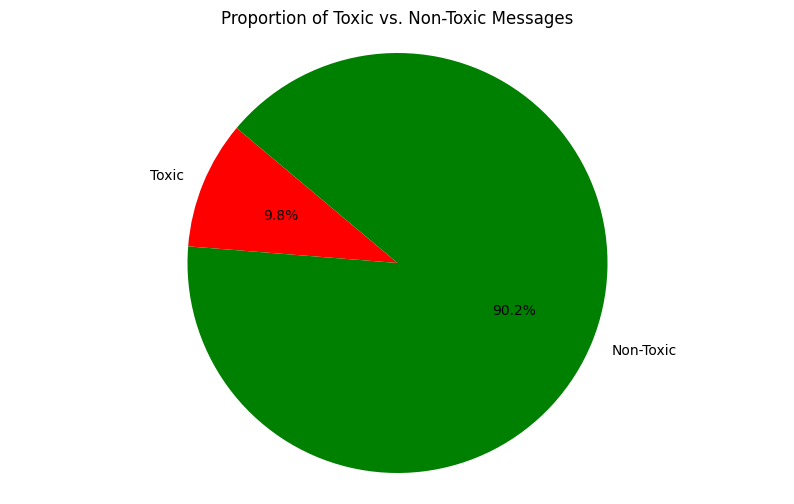

<Figure size 1200x600 with 0 Axes>

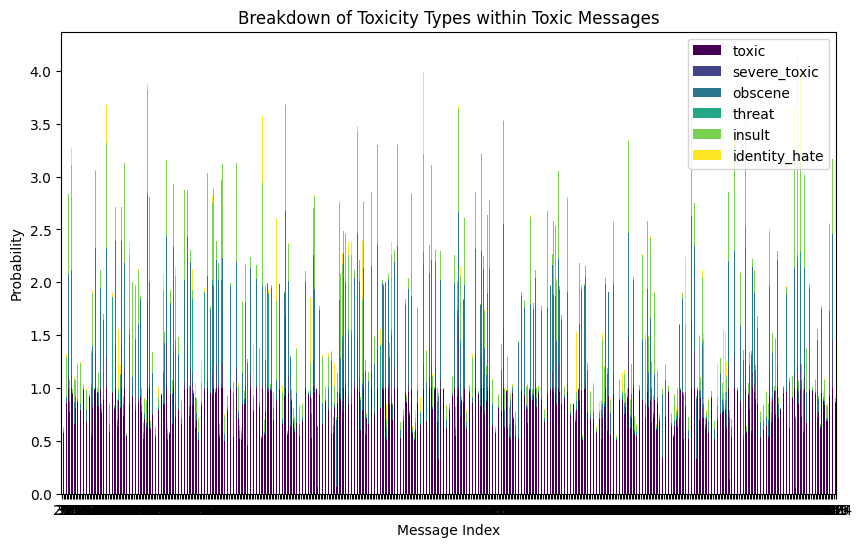

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Column names
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Convert predictions to DataFrame
df = pd.DataFrame(alt_predictions, columns=columns)

# Clip probabilities to ensure they are between 0 and 1
df = df.clip(0, 1)

# Determine toxic and non-toxic messages
threshold = 0.5
is_toxic = (df > threshold).any(axis=1)
toxic_count = is_toxic.sum()
non_toxic_count = (~is_toxic).sum()

# Plot 1: Pie chart for proportion of toxic vs. non-toxic messages
plt.figure(figsize=(10, 6))
labels = ['Toxic', 'Non-Toxic']
sizes = [toxic_count, non_toxic_count]
colors = ['red', 'green']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Toxic vs. Non-Toxic Messages')
plt.axis('equal')
plt.show()

# Plot 2: Stacked bar plot for breakdown of each toxicity type within toxic messages
toxic_df = df[is_toxic]

plt.figure(figsize=(12, 6))
toxic_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title('Breakdown of Toxicity Types within Toxic Messages')
plt.xlabel('Message Index')
plt.ylabel('Probability')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()
